# Basic Study of the 20 Newsgroups Dataset

Here we do some text preprocessing and analysis.

The study presented here is also a part of the notebook [Making-Decorrelation-and-Topic-Selection-Friends.ipynb](https://github.com/machine-intelligence-laboratory/TopicNet/blob/master/topicnet/demos/Making-Decorrelation-and-Topic-Selection-Friends.ipynb) in [TopicNet's library repo](https://github.com/machine-intelligence-laboratory/TopicNet).

In [1]:
# General

from collections import Counter
import numpy as np

# Data

from sklearn.datasets import fetch_20newsgroups

# Plots

from matplotlib import pyplot as plt

%matplotlib inline

Default font size in plots

In [2]:
plt.rcParams['font.size']

10.0

We make it bigger

In [3]:
plt.rcParams.update({'font.size': 20})

# Dataset

Loading full train and test data

In [4]:
full_train_dataset = fetch_20newsgroups(
    subset='train',
    random_state=42
)
full_test_dataset = fetch_20newsgroups(
    subset='test',
    random_state=42
)

Loading reduced versions without meta data (eg. headers, footers), so as to train models on just plain text.

In [5]:
train_dataset = fetch_20newsgroups(
    subset='train',
    remove=('headers', 'footers', 'quotes'),
    random_state=42
)
test_dataset = fetch_20newsgroups(
    subset='test',
    remove=('headers', 'footers', 'quotes'),
    random_state=42
)

There are 20 topics in the dataset, some are closely related to each other.

In [6]:
train_dataset.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

Texts are arranged in list

In [7]:
type(train_dataset.data)

list

Let's look at one piece of text from train data

In [8]:
train_dataset.data[0]

'I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.'

Targets are encoded known text topics

In [9]:
train_dataset.target[:5]

array([ 7,  4,  4,  1, 14])

# Basic Study

How many documents are there in train and test datasets?

In [10]:
def size_mb(docs):
    return sum(len(s.encode('utf-8')) for s in docs) / 10 ** 6

train_dataset_size_mb = size_mb(train_dataset.data)
test_dataset_size_mb = size_mb(test_dataset.data)

print(f'{len(train_dataset.data):5d} documents,  {train_dataset_size_mb:7.3f} MB (train)')
print(f'{len(test_dataset.data):5d} documents,  {test_dataset_size_mb:7.3f} MB (test)')

11314 documents,   13.782 MB (train)
 7532 documents,    8.262 MB (test)


How many documents are in each topic?

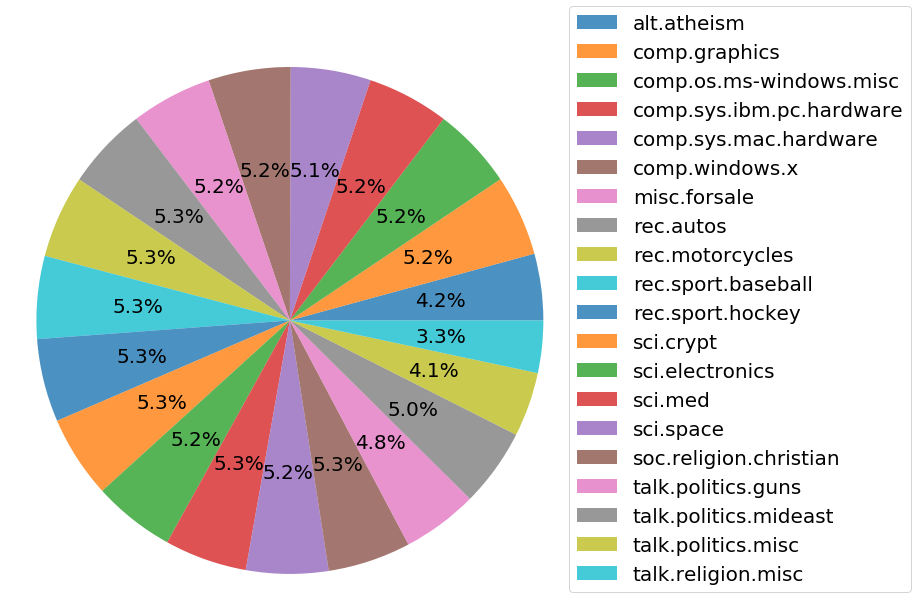

In [11]:
figure = plt.figure(figsize=(10, 10))

targets, sizes = np.unique(train_dataset.target, return_counts=True)
target_names = [train_dataset.target_names[i] for i in targets]

patches, _, _ = plt.pie(sizes, autopct='%1.1f%%', wedgeprops={'alpha': 0.8})

plt.legend(patches, target_names, loc=(1, 0.0))

plt.axis('equal')
plt.show()

Topics have roughly the same number of documents

It might also be useful to look at some language statistical properties: words distribution, document lengths distribution.
Below are just some functions for analyzing texts.

In [12]:
COLOR = (176/255, 0, 0)
FIGSIZE = (15, 10)
SMALL_FIGSIZE = (10, 6)
LINEWIDTH = 5
LABELPAD = 10


# https://en.wikipedia.org/wiki/Zipf%27s_law

def draw_zipfs_plot(
        texts,
        low_outlier_percentile_bound=1,
        upper_outlier_percentile_bound=99,
        ax=None):

    counter = Counter(' '.join(texts).split())
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=FIGSIZE)
    else:
        fig = None
    
    frequencies = [freq for word, freq in counter.most_common()]
    low_outlier_bound = np.percentile(frequencies, low_outlier_percentile_bound)
    upper_outlier_bound = np.percentile(frequencies, upper_outlier_percentile_bound)
    frequencies = [freq for freq in frequencies if freq > low_outlier_bound and freq <= upper_outlier_bound]
    
    ranks = range(1, len(frequencies) + 1)
    
    ax.plot(ranks, frequencies, lw=LINEWIDTH, color=COLOR)
    
    ax.set_xlabel('Rank', labelpad=LABELPAD)
    ax.set_ylabel('Frequency', labelpad=LABELPAD)
    ax.set_title('Zipf\'s law')
    
    if fig is not None:
        plt.show()

    return ax


# https://en.wikipedia.org/wiki/Heaps%27_law

def draw_heaps_plot(
        texts,
        in_symbols=True,
        ax=None):

    if in_symbols is True:
        lengths = [len(t) for t in texts]
        length_units = 'symbols'
    else:
        lengths = [len(t.split()) for t in texts]
        length_units = 'words'

    num_uniques = [len(set(t.split())) for t in texts]
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=FIGSIZE)
    else:
        fig = None
    
    ax.scatter(lengths, num_uniques, s=4 * LINEWIDTH ** 2, color=COLOR)
    
    ax.set_xlabel(f'Document length ({length_units})', labelpad=LABELPAD)
    ax.set_ylabel('Number of unique tokens', labelpad=LABELPAD)
    ax.set_title('Heaps\' law')
    
    if fig is not None:
        plt.show()

    return ax


def draw_document_lengths_histogram(
        texts,
        in_symbols=False,
        low_outlier_percentile_bound=1,
        upper_outlier_percentile_bound=99,
        bins=200,
        ax=None):

    if in_symbols is True:
        lengths = [len(t) for t in texts]
        length_units = 'symbols'
    else:
        lengths = [len(t.split()) for t in texts]
        length_units = 'words'

    low_outlier_bound = np.percentile(lengths, low_outlier_percentile_bound)
    upper_outlier_bound = np.percentile(lengths, upper_outlier_percentile_bound)
    lengths = [l for l in lengths if l > low_outlier_bound and l <= upper_outlier_bound]
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=FIGSIZE)
    else:
        fig = None
    
    ax.hist(lengths, bins=bins, color=COLOR)
    
    ax.set_xlabel(f'Document length ({length_units})', labelpad=LABELPAD)
    ax.set_ylabel('Number of documents', labelpad=LABELPAD)
    ax.set_title('Document lengths distribution')
    
    if fig is not None:
        plt.show()

    return ax

Analyzing train dataset

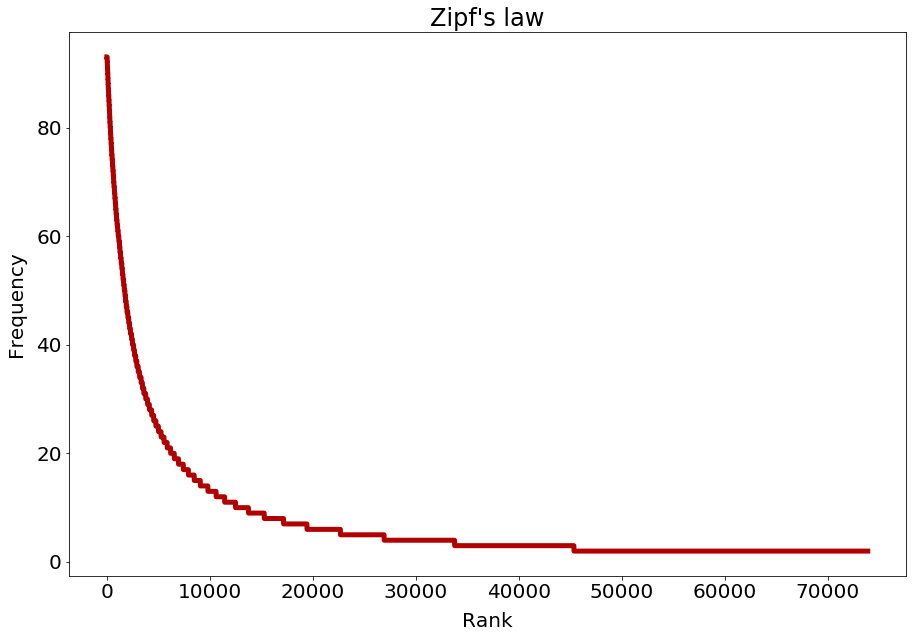

In [13]:
draw_zipfs_plot(train_dataset.data)

plt.show()

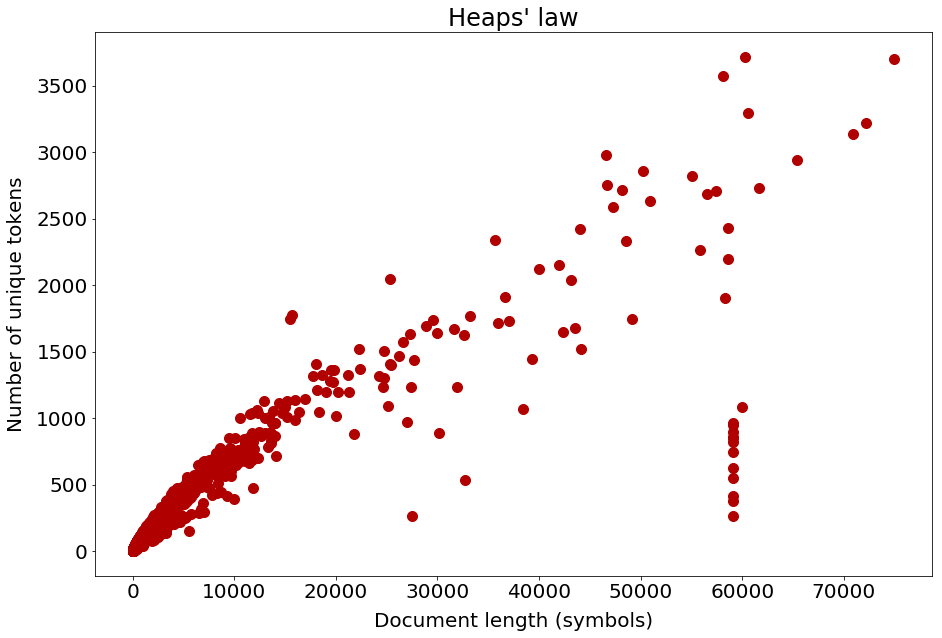

In [14]:
draw_heaps_plot(train_dataset.data)

plt.show()

There is a noticeable drop out of the general trend (near document length = 60.000).
Let's look at these documents

In [15]:
lengths = [len(t) for t in train_dataset.data]
num_uniques = [len(set(t.split())) for t in train_dataset.data]

In [16]:
suspicious_indices = [i for i, l in enumerate(lengths) if l >= 58000 and l <= 60000 and num_uniques[i] < 1500]

In [17]:
len(suspicious_indices)

13

In [18]:
print(full_train_dataset.data[suspicious_indices[-1]][:5000])

Subject: roman.bmp 01/14In response to the requests for cool bitmaps I am posting one.
From: pwiseman@salmon.usd.edu (Cliff)
Reply-To: pwiseman@salmon.usd.edu (Cliff)
Distribution: usa
Organization: University of South Dakota
Lines: 978


Due to the resolution and size it is in 14 parts.

This is a uuencoded bitmap.  960X600 256 colors.
The picture is a marbled gazebo on a desert with blue sky background.
The size is just right for centered wallpaper on a 1024x768 display
because it leaves a border at the bottom just big enough for icons
to fit in without being on top of the picture. Reguarding image
quality and resolution - I have not seen much better.

For those of you who haven't worked with pieced image files, here
is how to put it back together.
	1. save the 14 parts to 14 individual files
	2. use a text editor to remove the header and footer
	   in each file.
	3. concatinate all the parts into a single file
	4. uudecode the file
There are tools available to do this without the ha

In [19]:
print(full_train_dataset.data[suspicious_indices[-2]][:1000])

Subject: roman.bmp 11/14 
From: pwiseman@salmon.usd.edu (Cliff)
Reply-To: pwiseman@salmon.usd.edu (Cliff)
Distribution: usa
Organization: University of South Dakota
Lines: 956



------------ Part 11 of 14 ------------
MR1865%22DM75U=75U4)"0IV=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=
MG9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=
MG9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=
MG9V=0M75U=625!;)B8E,3`]G9S2+[>WM4QD]F0->7EXJWZ5F,8>'AX>'AX>'
MAX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'
MAX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'
MAX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'
MAX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'
MAX>'AX<Q9J5ZNP.9F3V9F9F9F3W2TG%Q&1FPL%-3[>WM[>WM[5-3L+!3L+`9
M&1D9&7%Q<7%Q<7%Q&7'2TCT]/=+2TM+2TM+2/3T]/3T]/=+2TG%QTCV9F0,#
M`P->7EZ[N[LJ>GIZW]]'1Z6EI0L+9F9F9F9F9F;$Q,3$Q,3$Q,3$9F8+"PL+
MI:5'>GHJ*BHJN[M>7EY>7@.9/3W2TG%Q<1D9L%-3[8N+-,5G9P],3$Q,3$Q,
M3$R)B8F)B8G)R<G)R<G)R<G)R186R<G)R<G)

In turns out, that the series of suspicious .txt files contain information about the uuencoded picture of some kind of roman gazebo!

![ROMAN](https://raw.githubusercontent.com/Alvant/20-newsgroups-secrets/master/secrets/images/ROMAN/ROMAN.jpg)

Decoded image and source .txt files can be found [here](https://github.com/Alvant/20-newsgroups-secrets/tree/master/secrets/images/ROMAN) on github

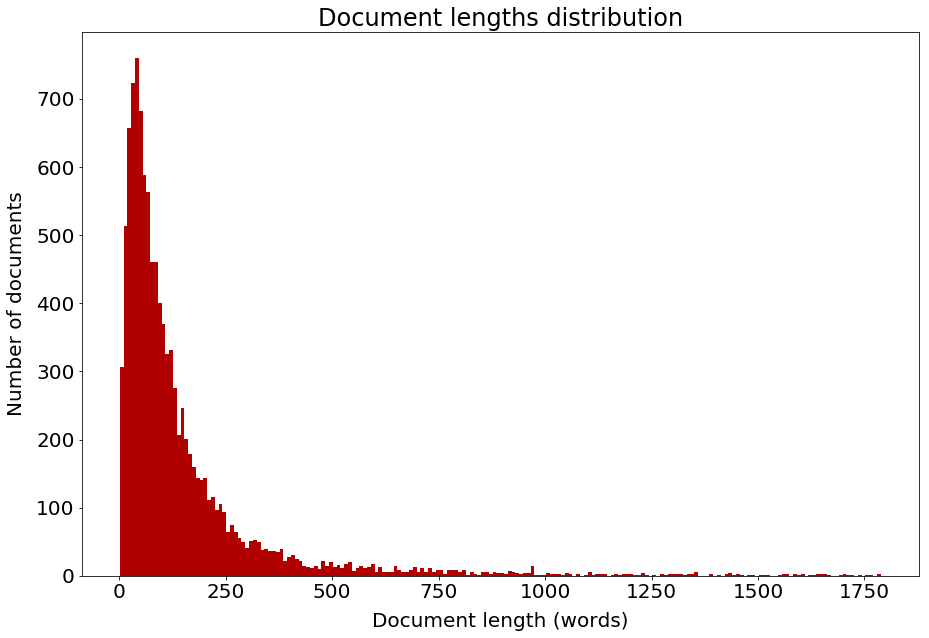

In [20]:
draw_document_lengths_histogram(train_dataset.data)

plt.show()

Let's look if there are some special documents in case of lengths: too short or too long

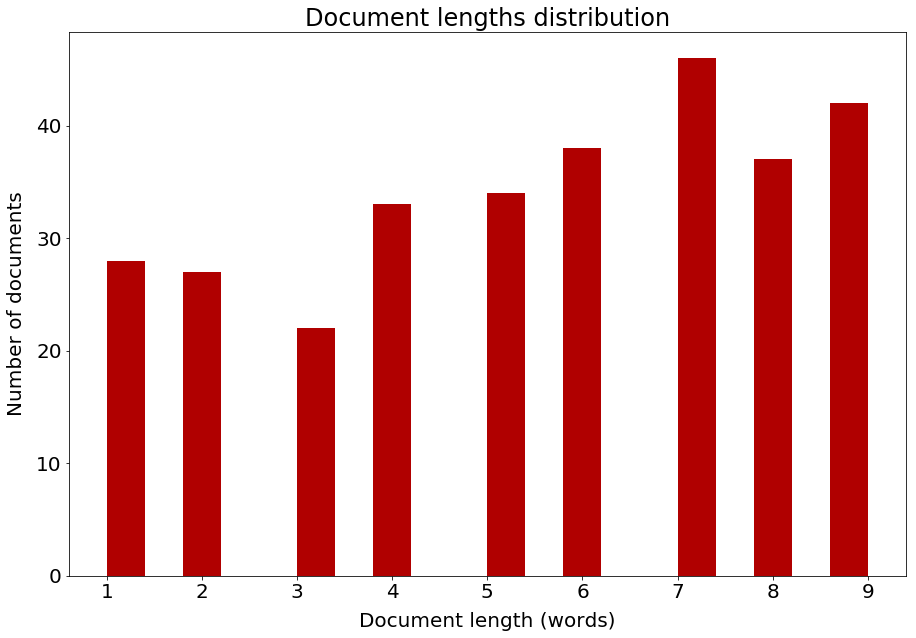

In [21]:
draw_document_lengths_histogram(
    train_dataset.data,
    low_outlier_percentile_bound=0,
    upper_outlier_percentile_bound=5,
    bins=20,
)

plt.show()

In [22]:
suspiciously_short_texts = [
    t for t in train_dataset.data
    if len(t.split()) <= 9
]

In [23]:
len(suspiciously_short_texts)

607

In [24]:
print(suspiciously_short_texts[0])

--



In [25]:
print(suspiciously_short_texts[11])

Woof woof!



Thus, most texts that are too short contain little information.

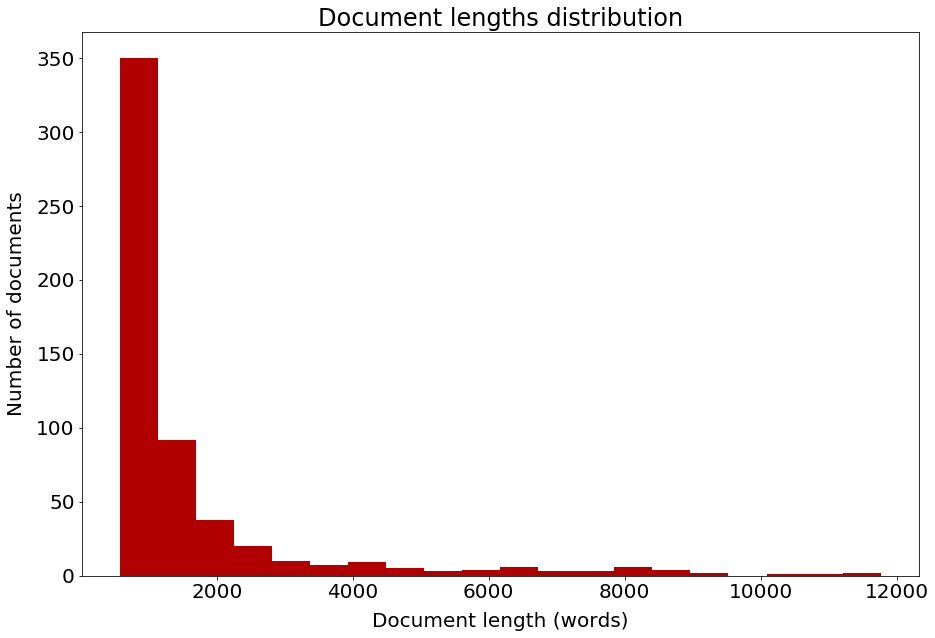

In [26]:
draw_document_lengths_histogram(
    train_dataset.data,
    low_outlier_percentile_bound=95,
    upper_outlier_percentile_bound=100,
    bins=20,
)

plt.show()

In [27]:
suspiciously_long_texts = [
    t for t in train_dataset.data
    if len(t.split()) >= 2000
]

In [28]:
len(suspiciously_long_texts)

91

In [29]:
print(suspiciously_long_texts[0][:1000])


: Pardon me? Here is to an amherst-clown:
: 
: "Your three chiefs, Dro, Hamazasp and Kulkhandanian are the ringleaders
:  of the bands which have destroyed Tartar villages and have staged 
:  massacres in Zangezour, Surmali, Etchmiadzin, and Zangibasar. This is
:  intolerable.


Were you expecting a different response? Here is another one:

Source: K. S. Papazian, "Patriotism Perverted," Baikar Press, Boston, 1934, 
        (73 pages with Appendix).

p. 25 (third paragraph)

"Some real fighters sprang up from among the people, who struck terror
 into the hearts of the Turks."


"Within a few months after the war began, these Armenian guerrilla
 forces, operating in close coordination with the Russians, were
 savagely attacking Turkish cities, towns and villages in the east,
 massacring their inhabitants without mercy, while at the same time
 working to sabotage the Ottoman army's war effort by destroying roads
 and bridges, raiding caravans, and doing whatever else they could to
 ease

In [30]:
print(suspiciously_long_texts[50][:1000])

Archive-name: cryptography-faq/part08
Last-modified: 1993/4/15


FAQ for sci.crypt, part 8: Technical Miscellany

This is the eighth of ten parts of the sci.crypt FAQ. The parts are
mostly independent, but you should read the first part before the rest.
We don't have the time to send out missing parts by mail, so don't ask.
Notes such as ``[KAH67]'' refer to the reference list in the last part.

The sections of this FAQ are available via anonymous FTP to rtfm.mit.edu 
as /pub/usenet/news.answers/cryptography-faq/part[xx].  The Cryptography 
FAQ is posted to the newsgroups sci.crypt, sci.answers, and news.answers
every 21 days.


Contents

* How do I recover from lost passwords in WordPerfect?
* How do I break a Vigenere (repeated-key) cipher?
* How do I send encrypted mail under UNIX? [PGP, RIPEM, PEM, ...]
* Is the UNIX crypt command secure?
* How do I use compression with encryption?
* Is there an unbreakable cipher?
* What does ``random'' mean in cryptography?
* What is the unicity 

So, there are some very long documents.
Some of them contain excerpts from other books.

And here is a more compact version, combining all the three mentioned plots

In [31]:
def draw_statistics(texts, figsize=(20, 15), font_size=16):
    old_font_size = plt.rcParams['font.size']
    
    try:
        plt.rcParams.update({'font.size': font_size})

        fig, axes = plt.subplots(2, 2, figsize=figsize)

        draw_zipfs_plot(
            texts,
            ax=axes[0][0],
        )
        draw_document_lengths_histogram(
            texts,
            ax=axes[0][1],
        )
        draw_heaps_plot(
            texts,
            ax=axes[1][0],
            in_symbols=True,
        )
        draw_heaps_plot(
            texts,
            ax=axes[1][1],
            in_symbols=False,
        )

    finally:
        plt.rcParams.update({'font.size': old_font_size})

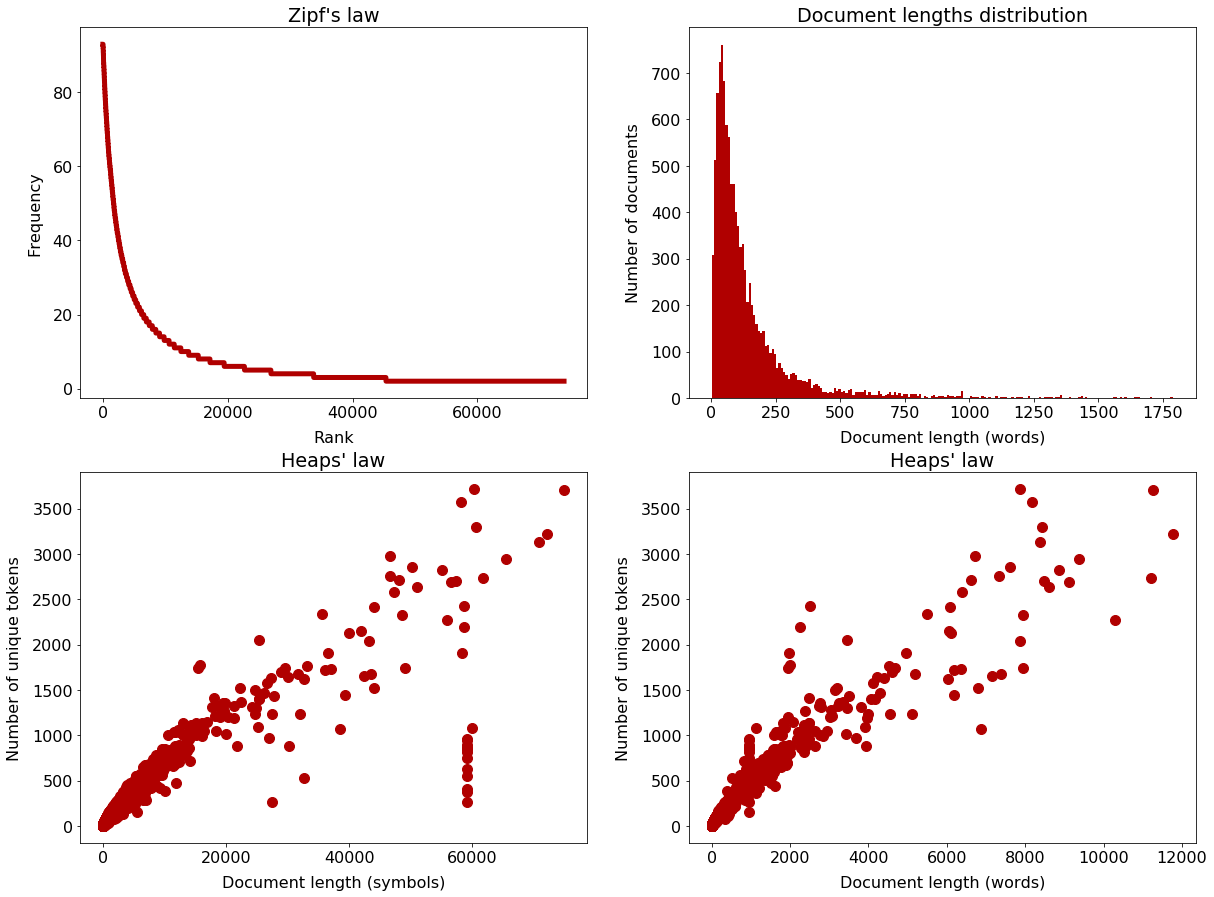

In [32]:
draw_statistics(train_dataset.data)

plt.show()

Let's look at the test part of the dataset

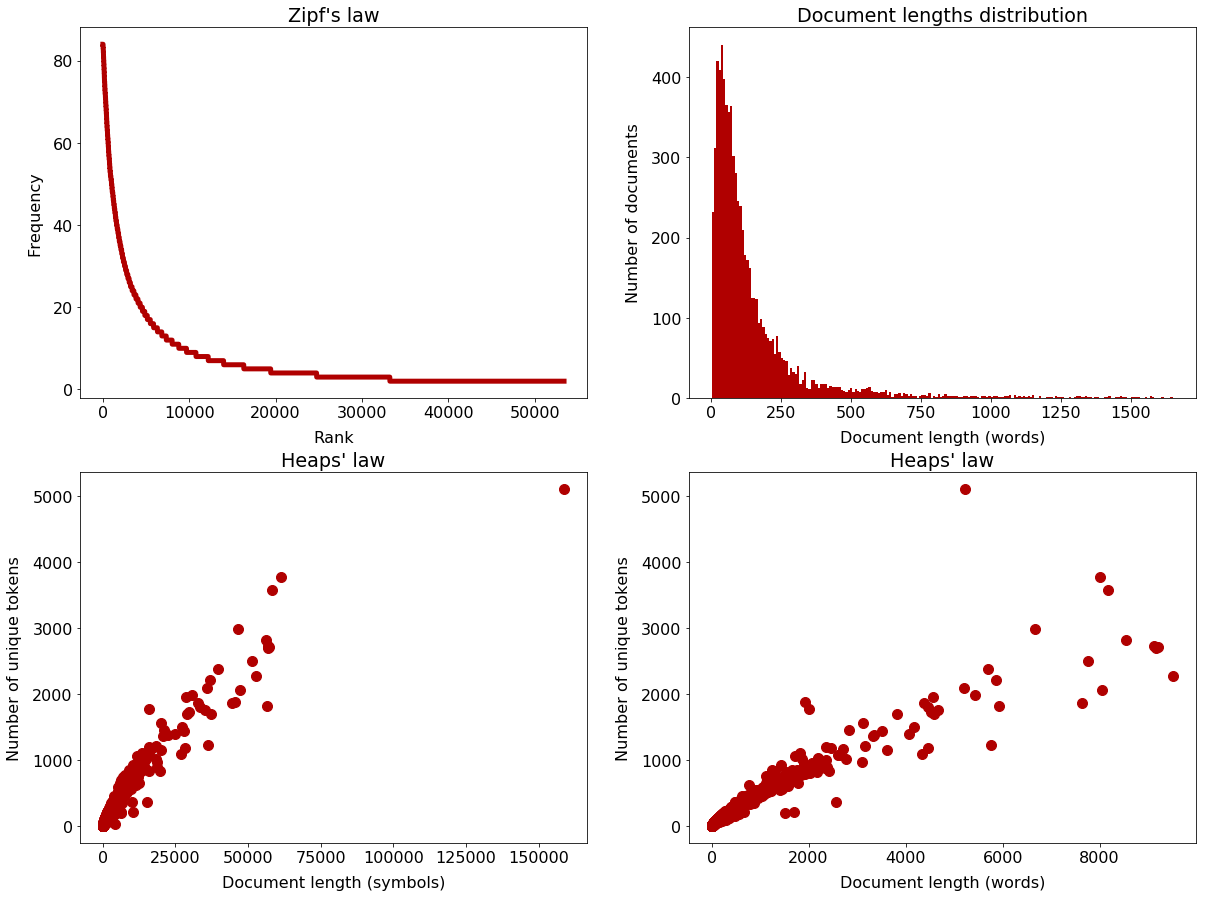

In [33]:
draw_statistics(test_dataset.data)

plt.show()

One document from test dataset has a lot of unique tokens inside...

In [34]:
interesting_document_index = np.argmax([len(set(t.split())) for t in test_dataset.data])

In [35]:
interesting_document_index

2015

In [36]:
len(set(test_dataset.data[interesting_document_index].split()))

5103

In [37]:
print(full_test_dataset.data[interesting_document_index][:5000])

From: dbushong@wang.com (Dave Bushong)
Subject: Re: More Cool BMP files??
Organization: Wang Labs, Lowell MA, USA
Distribution: usa
Lines: 2603

adair@atldbs.dbsoftware.com (Owen Adair) writes:

>In article <1993Apr20.173506.2288@dlss2> james@dlss2 (James Cummings) writes:
>>Newsgroups: comp.os.ms-windows.misc
>>Path: atldbs!uupsi!psinntp!uunet!gatech!howland.reston.ans.net!bogus.sura.net!darwin.sura.net!convex!seas.smu.edu!void!dalnet!dlss2!james
>>From: james@dlss2 (James Cummings)
>>Subject: Re: More Cool BMP files??
>>Message-ID: <1993Apr20.173506.2288@dlss2>
>>Organization: RedRock Development
>>References: <1993Apr17.023017.17301@gmuvax2.gmu.edu>
>>Distribution: usa
>>Date: Tue, 20 Apr 1993 17:35:06 GMT
>>Lines: 1021
>>In article <1993Apr17.023017.17301@gmuvax2.gmu.edu> rwang@gmuvax2.gmu.edu (John Wang) writes:
>> |Hi, everybody:
>> |    I guess my subject has said it all.  It is getting boring
>> |looking at those same old bmp files that came with Windows.  So,
>> |I am wonderin

If we decode this uuencoded file, we get an archive with the following picture inside...

![BUTT](https://raw.githubusercontent.com/Alvant/20-newsgroups-secrets/master/secrets/images/BUTT/BUTT.jpg)

Decoded image and source .txt files can be found [here](https://github.com/Alvant/20-newsgroups-secrets/tree/master/secrets/images/BUTT) on github

Maybe there are some other interesting emails from Dave Bushong?

In [38]:
bushong_mails = [t for t in full_train_dataset.data + full_test_dataset.data if 'Dave Bushong' in t]

In [39]:
len(bushong_mails)

2

Only two of them. And the other one is

In [40]:
print(bushong_mails[1])

From: dbushong@wang.com (Dave Bushong)
Subject: Re: TIFF: philosophical significance of 42 (SILLY)
Organization: Wang Labs, Lowell MA, USA
Lines: 10

rak@crosfield.co.uk (Richard Kirk) writes:

>It's the number of legs on a centipede.
>So, now you know.

Is that the number of "left" legs, or both left and right?
-- 
Dave Bushong, Wang Laboratories, Inc.   Amateur Radio Callsign KZ1O
Project Leader, Recognition products    kz1o@n0ary.#noca.ca.na
Internet: dbushong@wang.com



Seems nothing interesting here anymore.